## Objective
The objective is to develop a predictive model that determines if a customer will submit a vehicle insurance claim in the next three months. This solution will help streamline financial planning at AutoInland and allow them to better serve their customers by understanding which customers are likely to submit a claim.

In [ ]:
import xgboost
xgboost.__version__

'0.90'

In [1]:
# Loading the required packages

import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, f1_score, plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline



from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

plt.rcParams["figure.figsize"] = (12,7)

# Looking at the data

* Exploring the data and performing feature engineering.

Before working with this data, personal data in this dataset must be protected according to the data protection law.
You must read this article to get the understanding of data minimisation and privacy preserving.<br>
https://ico.org.uk/about-the-ico/news-and-events/ai-blog-data-minimisation-and-privacy-preserving-techniques-in-ai-systems/

In [2]:
train= pd.read_csv('Train.csv') # loads the training set
test= pd.read_csv('Test.csv') # loadsd the test set

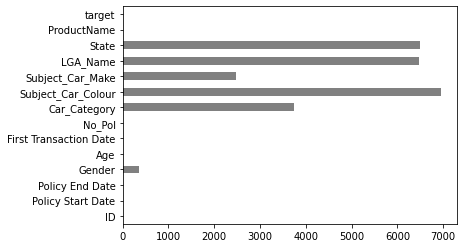

In [3]:
# the figure below shows the frtequency of missing values
# in each feature of the training data.
train.isnull().sum().plot(kind='barh', color= 'grey')

In [4]:
train.isnull().sum() # it the number of missing values in wach feature.

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     359
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              3738
Subject_Car_Colour        6962
Subject_Car_Make          2476
LGA_Name                  6476
State                     6488
ProductName                  0
target                       0
dtype: int64

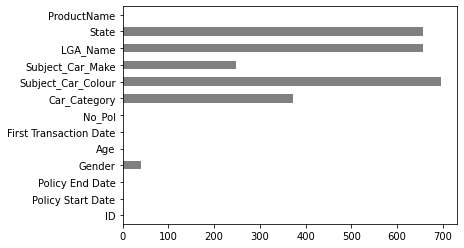

In [5]:
test.isnull().sum().plot(kind='barh', color= 'grey') # shows the plot of missing values in the
                                                        # test set

In [ ]:
test.isnull().sum() # shows the number of missing values of the test set.

ID                          0
Policy Start Date           0
Policy End Date             0
Gender                     41
Age                         0
First Transaction Date      0
No_Pol                      0
Car_Category              372
Subject_Car_Colour        697
Subject_Car_Make          248
LGA_Name                  656
State                     656
ProductName                 0
dtype: int64

In [ ]:
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [ ]:
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


## processing the data

In [6]:
combined_data= pd.concat((train, test)).reset_index(drop=True)

In [7]:
print(combined_data.info())
print('-----')
print('shape:: ', combined_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      13281 non-null  object 
 1   Policy Start Date       13281 non-null  object 
 2   Policy End Date         13281 non-null  object 
 3   Gender                  12881 non-null  object 
 4   Age                     13281 non-null  int64  
 5   First Transaction Date  13281 non-null  object 
 6   No_Pol                  13281 non-null  int64  
 7   Car_Category            9171 non-null   object 
 8   Subject_Car_Colour      5622 non-null   object 
 9   Subject_Car_Make        10557 non-null  object 
 10  LGA_Name                6149 non-null   object 
 11  State                   6137 non-null   object 
 12  ProductName             13281 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

In [8]:
# Assigning the correct data type to each feature in the "combined data".

for i in ['Policy Start Date', 'Policy End Date', 'First Transaction Date']:
     combined_data[i] = pd.to_datetime(combined_data[i])

for i in ['Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 
          'LGA_Name', 'State', 'ProductName']:
      combined_data[i] = combined_data[i].astype('category')

In [9]:
combined_data.info()
print('shape ', combined_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  category      
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10557 non-null  category      
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

# Distribution of features in the data.

## Distribution of genders

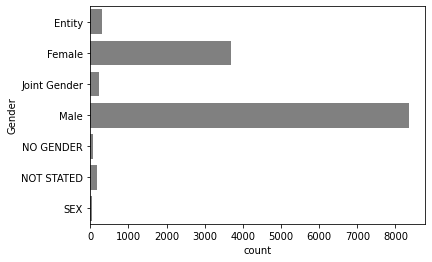

In [10]:
sns.countplot(y = combined_data['Gender'], color= 'grey')

## Distribution of Ages

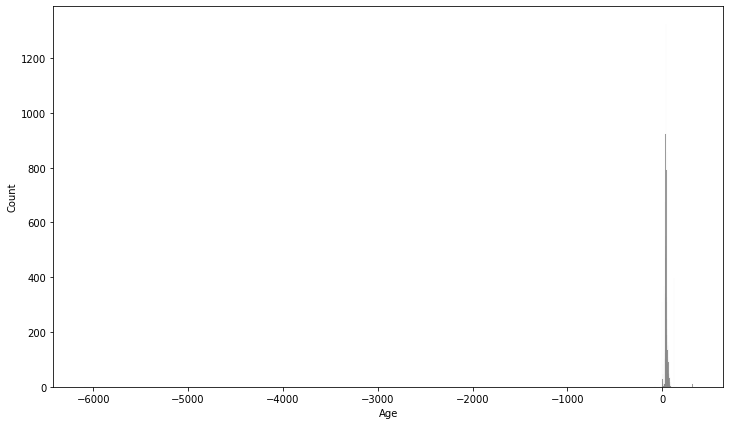

In [ ]:
sns.histplot(combined_data['Age'], color='grey')

The plot below suggests that age columns is full of messy inputs, so the best thing to do is to set the ideal age of which one could get insured.

Now, the age is close to normal, this makes it a perfect feature for generalization in many ML algorithms.

In [11]:
# checking the number of uniques in the categorical data..
for i in list(combined_data.select_dtypes('category')):
     print('number of uniques of '+str(i)+ ":  " , combined_data[i].nunique())

number of uniques of Gender:   7
number of uniques of Car_Category:   16
number of uniques of Subject_Car_Colour:   46
number of uniques of Subject_Car_Make:   75
number of uniques of LGA_Name:   270
number of uniques of State:   113
number of uniques of ProductName:   9


In [12]:
# replacing extreme values in ages with **nan**
combined_data['Age'] = np.where((combined_data['Age'] <18),np.nan, combined_data['Age'])
combined_data['Age'] = np.where((combined_data['Age'] >80),np.nan, combined_data['Age'])

In [13]:
combined_data['Age'].unique()

array([30., 79., 43., nan, 20., 37., 40., 71., 58., 45., 51., 38., 69.,
       31., 70., 34., 41., 47., 36., 46., 48., 39., 63., 42., 27., 64.,
       50., 53., 33., 23., 32., 59., 60., 52., 54., 44., 78., 28., 29.,
       57., 65., 35., 73., 56., 55., 26., 49., 18., 62., 25., 61., 72.,
       67., 68., 21., 76., 24., 66., 22., 77., 19., 80., 74., 75.])

Text(0.5, 1.0, 'Age Distribution')

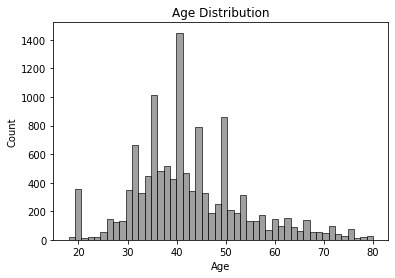

In [14]:
sns.histplot(combined_data['Age'], color = 'grey') # shows the histogram plot of the ages column
plt.title('Age Distribution')

In [15]:
# Cleaning up the data.
combined_data['Age'].fillna(combined_data['Age'].mean(), inplace= True)

for i in list(combined_data.select_dtypes('category')):
    combined_data[i] = combined_data[i].fillna(combined_data[i].mode()[0]) # replaces mising categorical data with
                                                                           # its mode..

for i in list(combined_data.select_dtypes('number')):
    combined_data[i] = combined_data[i].fillna(9999) # replaces missing numerical data with 9999

In [16]:
combined_data.isnull().sum() # checking if there is still missing values

ID                        0
Policy Start Date         0
Policy End Date           0
Gender                    0
Age                       0
First Transaction Date    0
No_Pol                    0
Car_Category              0
Subject_Car_Colour        0
Subject_Car_Make          0
LGA_Name                  0
State                     0
ProductName               0
target                    0
dtype: int64

## Feature engineering

In [17]:
# the code below extracts variuos features from the **datetime** datatype.
date_cols= combined_data.select_dtypes('datetime')
for col in date_cols:
    for date_feature in ['year', 'month', 'day']:
        combined_data[col+date_feature] = getattr(combined_data[col].dt, date_feature)

In [18]:
### Reducing the number of categorical features 

# Product Name 
prod_map1= {
           'Customized Motor':'other', 
           'Motor Cycle':'other', 
           'Car Vintage':'other',
           'Muuve': 'other'
           }
combined_data['ProductName'].replace(prod_map1, inplace= True)

# gender
gender_mapper = {
                 'Entity':'Other', 
                 'Joint Gender':'Other', 
                 'NOT STATED':'Other', 
                 'NO GENDER': 'Other', 
                 'SEX':"Other"
                 }
combined_data['Gender'] .replace(gender_mapper, inplace= True)

# car category
vehi_mapper = {'Station 4 Wheel':'Other', 
               'Shape Of Vehicle Chasis':'Other', 
               'JEEP':'SUV', 
               'Wagon': 'Other', 
               'Mini Van': 'Van',
               'Mini Bus': 'Bus',
               'CAMRY CAR HIRE':"Sedan",
               'Tipper Truck':'Truck',
               'Pick Up': 'Truck',
               'Pick Up > 3 Tons': 'Truck',
               'Sedan':'Other',
               'Van':'Other',
               'Motorcycle':'Other'
               }
combined_data['Car_Category'] .replace(vehi_mapper, inplace= True)

# car make
map_make= {'Tata':'other', 'Motorcycle':'other',
           'ZOYTE':'other','Lincoln':'other',
           'CHANGAN':'other','ABG':'other',
           'Yamaha':'other', 
           'Ashok Leyland':'other', 
           'FOTON':'other', 
           'Geely':'other', 
           'Raston':'other',
           'MG':'other',
            'Black':'other' , 
           'Innson':'other',  'Man':'other', 'Fiat':'other',  'Black':'other', 'Opel':'other', 'Astra':'other', 'Howo':'other',
           'MINI COOPER':'other', 'LIBERTY':'other','GMC':'other', 'Caddillac':'other', 'Wrangler Jeep':'other', 'COMMANDER':'other',
           'Subaru':'other','Renault':'other','As Attached':'other', 'Bajaj':'other', 'Datsun':'other', 'Jincheng':'other',
           'Dodge':'other','Dodge':'other','Scania':'other',
           'Buik':'other','BRILLIANCE':'other','Chrysler':'other',
           'Jaguar':'other','Man':'other','Isuzu':'other',
           'GAC':'other','Land Rover.':'other','GMC':'other',
           'Rols Royce':'other','Hummer':'other','KA':'other',
           'Grand Cherokee':'other','Dodge':'other','Scania':'other',
           'Infiniti':'other','Volvo':'other','BMW':'other','Mack':'other',
           'Porsche':'other','Peugeot':'other','Land Rover':'other',
           'Mazda':'other','Jeep':'other','Audi':'other',
           'Suzuki':'other','Chevrolet':'other','Skoda':'other',
           'Seat':'other',
           'Pontiac':'other',
           'DAF':'other',
           'REXTON':'other',
           '.':'other', 
           }
combined_data['Subject_Car_Make'].replace(map_make, inplace= True)

# car color
col_map= {'Ash':'other', 'Yellow':'other','Gold':'other',
          'Gray & Gray':'other','Green':'other',
          'Silver':'other','Cream':'other', 'Blue & Red':'other',
          'Gray & Gray':'other','Green':'other',
          'As Attached':'other', 'Red & Blue':'other','Gray & Silver':'other',
          'Orange':'other','B.Silver':'other','Purple':'other',
          'Red & Yellow':'other','Red & White':'other','Dark Green':'other',
          'Black & White':'other',
          'White & Red':'other', 'Dark Grey':'other','Light Green':'other',
          'Dark Gray':'other','D. Gold':'other','Champagne':'other','Light Blue':'other',
          'Blue&White&Red':'other','White & Yellow':'other','Dark Blue':'other',
          'D. Red':'other','Dark Red':'other','Black & Orange':'other','Burgundy':'other',
          'Yellow & White':'other','Beige Mitalic':'other','Light Gray':'other',
          'Blue Sky':'other','Red Maroon':'other','Red & Black':'other',
          'White & Blue':'other',
          }
combined_data['Subject_Car_Colour'].replace(col_map, inplace=True)


In [19]:
combined_data['ProductName'].unique()

array(['Car Classic', 'CarSafe', 'other', 'CVTP', 'Car Plus', 'CarFlex'],
      dtype=object)

Text(0.5, 1.0, 'Produt Name')

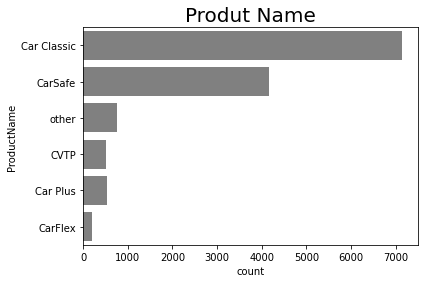

In [20]:
sns.countplot(y = combined_data['ProductName'], color='grey')
plt.title('Produt Name', size= 20)

Text(0.5, 1.0, 'Car Make')

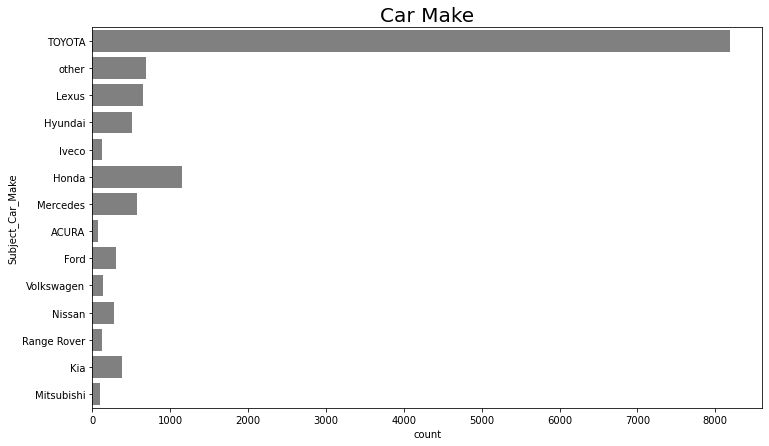

In [ ]:
sns.countplot(y= combined_data['Subject_Car_Make'], color= 'grey')
plt.title('Car Make', size= 20)

Text(0.5, 1.0, 'Car Color')

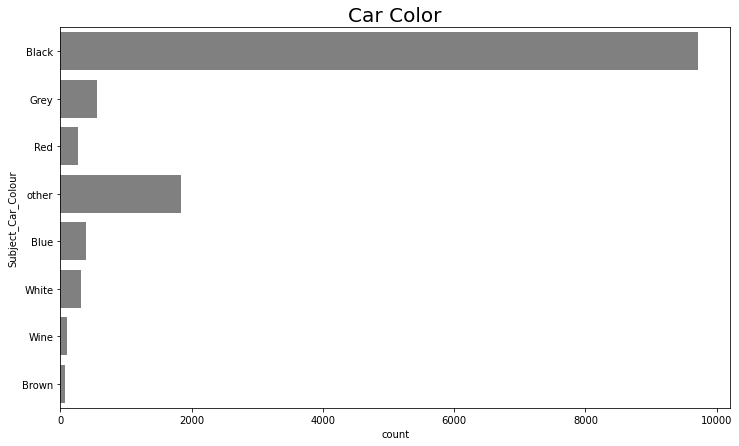

In [ ]:
sns.countplot(y = combined_data['Subject_Car_Colour'], color= 'grey')
plt.title('Car Color', size= 20)

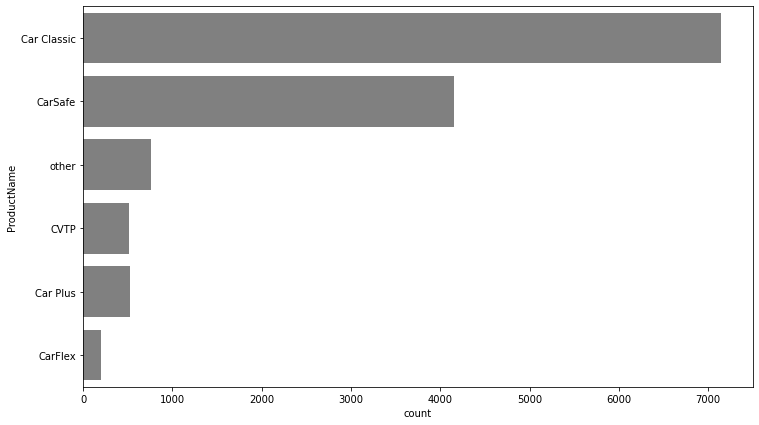

In [ ]:
sns.countplot(y = combined_data['ProductName'], color= 'grey')

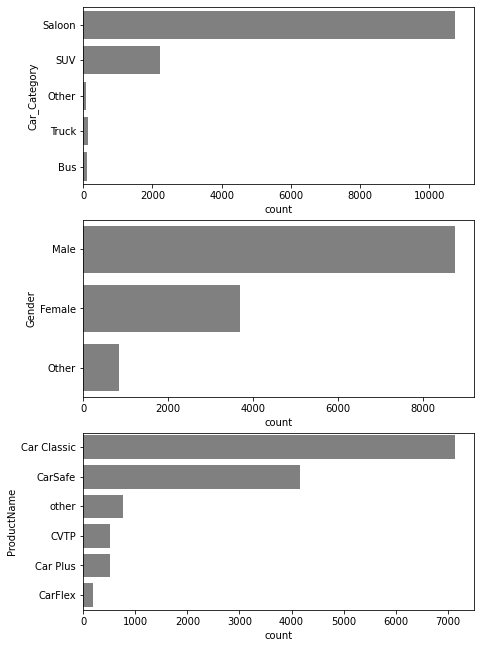

In [ ]:
plt.figure(figsize= (7, 15))

for index, col in enumerate(['Car_Category', 'Gender', 'ProductName']):
    plt.subplot(4, 1, index+1)
    sns.countplot(y= combined_data[col], color= 'grey')


In [21]:
combined_data['Age'].describe()

count    13281.000000
mean        42.634535
std         10.825180
min         18.000000
25%         36.000000
50%         42.000000
75%         48.000000
max         80.000000
Name: Age, dtype: float64

In [22]:
# creating new feature for the ages by grouping them into age groups.
combined_data['adult'] = combined_data['Age'].apply(lambda x: 1 if x >= 18 and x<= 35 else 0)
combined_data['middle age']= combined_data['Age'].apply(lambda x: 1 if x >= 36 and x<= 55 else 0)
combined_data['old age']= combined_data['Age'].apply(lambda x: 1 if x >= 56 and x<= 80 else 0)

In [35]:
combined_data.head()

,ID,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday,Gender,Age,adult,middle age,old age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,ProductName,target
0,ID_0040R73,2010,5,14,2011,5,13,2010,5,14,Male,30.000000,1,0,0,1,Saloon,Black,TOYOTA,Car Classic,0.0
1,ID_0046BNK,2010,11,29,2011,11,28,2010,11,29,Female,79.000000,0,0,1,1,SUV,Grey,TOYOTA,Car Classic,1.0
2,ID_005QMC3,2010,3,21,2011,3,20,2010,3,21,Male,43.000000,0,1,0,1,Saloon,Red,TOYOTA,Car Classic,0.0
3,ID_0079OHW,2010,8,21,2011,8,20,2010,8,21,Male,42.634535,0,1,0,1,Saloon,Black,TOYOTA,CarSafe,0.0
4,ID_00BRP63,2010,8,29,2010,12,31,2010,8,29,Other,20.000000,1,0,0,3,Saloon,Black,TOYOTA,other,1.0


In [36]:
# Now we rearrange the columns and selecting specific columns

combined_data = combined_data[[
 'ID',
 'Policy Start Dateyear',
 'Policy Start Datemonth',
 'Policy Start Dateday',
 'Policy End Dateyear',
 'Policy End Datemonth',
 'Policy End Dateday',
 'First Transaction Dateyear',
 'First Transaction Datemonth',
 'First Transaction Dateday',
 'Gender',
 'Age',
 'adult',
 'middle age',
 'old age',
 'No_Pol',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'ProductName',
 'target']  ]

In [26]:
combined_data.head()

,ID,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday,Gender,Age,adult,middle age,old age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,ProductName,target
0,ID_0040R73,2010,5,14,2011,5,13,2010,5,14,Male,30.000000,1,0,0,1,Saloon,Black,TOYOTA,Car Classic,0.0
1,ID_0046BNK,2010,11,29,2011,11,28,2010,11,29,Female,79.000000,0,0,1,1,SUV,Grey,TOYOTA,Car Classic,1.0
2,ID_005QMC3,2010,3,21,2011,3,20,2010,3,21,Male,43.000000,0,1,0,1,Saloon,Red,TOYOTA,Car Classic,0.0
3,ID_0079OHW,2010,8,21,2011,8,20,2010,8,21,Male,42.634535,0,1,0,1,Saloon,Black,TOYOTA,CarSafe,0.0
4,ID_00BRP63,2010,8,29,2010,12,31,2010,8,29,Other,20.000000,1,0,0,3,Saloon,Black,TOYOTA,other,1.0


In [ ]:
print('Number of Adults:: ', np.sum(combined_data['adult']))
print('Number of Middle-Age:: ', np.sum(combined_data['middle age']))
print('Number of Old-Age:: ', np.sum(combined_data['old age']))

Number of Adults::  3164
Number of Middle-Age::  8584
Number of Old-Age::  1533


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Target Class')

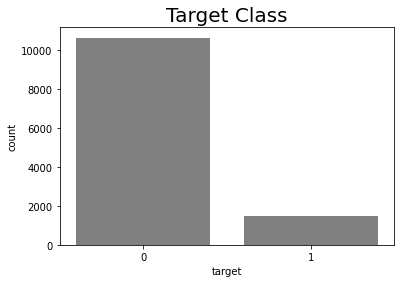

In [27]:
sns.countplot(train['target'], color= 'grey')
plt.title('Target Class', size= 20)

In [28]:
train['target'].value_counts(normalize=True)

0    0.879543
1    0.120457
Name: target, dtype: float64

The plot above makes it clear that, the data is very unbalance with about 12% of the target belonging to  **class 1** and 87% of the target belonging to **class 0**

# Model building phase.

* Splitting the data, transforming and fitting several Machine Learning Models to the dataset.
* I will be using **Random Forest Classifier, XGboost and Logistic Regression**

In [37]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   ID                           13281 non-null  object  
 1   Policy Start Dateyear        13281 non-null  int64   
 2   Policy Start Datemonth       13281 non-null  int64   
 3   Policy Start Dateday         13281 non-null  int64   
 4   Policy End Dateyear          13281 non-null  int64   
 5   Policy End Datemonth         13281 non-null  int64   
 6   Policy End Dateday           13281 non-null  int64   
 7   First Transaction Dateyear   13281 non-null  int64   
 8   First Transaction Datemonth  13281 non-null  int64   
 9   First Transaction Dateday    13281 non-null  int64   
 10  Gender                       13281 non-null  category
 11  Age                          13281 non-null  float64 
 12  adult                        13281 non-null  int64   
 13  m

In [38]:
# re-checking the unique categories
for i in list(combined_data.select_dtypes('category')):
    print('number of uniques of '+str(i)+ ":  " , combined_data[i].nunique())

number of uniques of Gender:   3
number of uniques of Car_Category:   7
number of uniques of Subject_Car_Colour:   8
number of uniques of Subject_Car_Make:   14
number of uniques of ProductName:   6


# Model Building Phase

In [39]:
rf = RandomForestClassifier(max_features=4, max_depth=3, n_estimators=500) # Initialize the Random Forest Classifier
lgm = LogisticRegression(C= 1000, max_iter=10000)  # Initialize the Logistic Regression Classifier
xgb= XGBClassifier(silent=False,                     # Initialize the XGBoost Claassifier
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

# initializes the encoders and scalers
ohe = OneHotEncoder()
sc = StandardScaler()
minmax = MinMaxScaler()
le = LabelEncoder()
oe = OrdinalEncoder()

# we omit 'Subject_Car_Make', 'LGA_Name' for now, due to data minimization and privacy preserving

# Categorical columns
cat_col = ['Gender', 'Car_Category', 'ProductName', 'Subject_Car_Colour', 'Subject_Car_Make', ]

# numeric columns 
num_col= ['Policy Start Dateyear', 'Policy Start Datemonth', 
           'Policy Start Dateday', 'Policy End Dateyear',
            'Policy End Datemonth', 'Policy End Dateday', 
           'First Transaction Dateyear', 'First Transaction Datemonth',
          'First Transaction Dateday', 'Age', 'adult',
          'middle age', 'old age','No_Pol']

# Initializes the column transformer and creates pipeline the data will pass through
# before it gets trained by the ML algorithm.
transformer = ColumnTransformer([('ohe', ohe, cat_col),  ('sc', sc, num_col)], remainder= 'drop')
pipe_logit= Pipeline([('transformer', transformer),  ('logit', lgm)])
pipe_rf= Pipeline([('transformer', transformer), ('rf', rf)])
pipe_xgb = Pipeline([('transformer', transformer), ('rf', xgb)])

In [40]:
# creating new training data with the new features.
# we will be using **df1** for now
df1 = combined_data[[
                    'Policy Start Dateyear', 'Policy Start Datemonth', 
                 'Policy Start Dateday', 'Policy End Dateyear',
               'Policy End Datemonth', 'Policy End Dateday', 
                  'First Transaction Dateyear', 'First Transaction Datemonth',
                  'First Transaction Dateday', 'Gender', 'Car_Category','Age',
                   'Subject_Car_Make',  'ProductName',  'adult', 'middle age',
  'Subject_Car_Colour', 'old age','No_Pol', 'target'
                    ]]

traindf = df1[df1['target'] < 2]
testdf = combined_data[combined_data['target'] > 2].iloc[:, 0:-1]

In [41]:
print('unique target: ',traindf['target'].unique()) # checks whether the target is truly binary

unique target:  [0. 1.]


In [42]:
print('test set before: ', test.shape)
print('test set after: ', testdf.shape)
print('----')
print('train set before: ', train.shape)
print('train set after: ', traindf.shape)


test set before:  (1202, 13)
test set after:  (1202, 20)
----
train set before:  (12079, 14)
train set after:  (12079, 20)


In [43]:
# splitting up the data into training and validation set
# we will be using (30%)of the training set for validation
X_train, X_val,  y_train, y_val= train_test_split(
                                                  traindf.iloc[:, :-1], 
                                                  traindf.iloc[:, -1], 
                                                  stratify=  traindf.iloc[:, -1], 
                                                  test_size= .3)

In [44]:
# fits the xgboost classifer
# makes prediction 
# then gets its f1_score, we used weighted average because it takes into consideration unbalance data
pipe_xgb.fit(X_train, y_train)
y_xgb_prd= pipe_xgb.predict(X_val)
print('acc score -> '+str(pipe_xgb.score(X_val, y_val)))
print('f1-score -> '+str(f1_score(y_val, y_xgb_prd)))

acc score -> 0.8805187637969095
f1-score -> 0.03991130820399113


In [45]:
# fits the Logit classifer
# makes prediction 
# then gets its f1_score, we used weighted average because it takes into consideration unbalance data

pipe_logit.fit(X_train, y_train)
pipe_logit.predict(X_val)
y_lg_prd= pipe_logit.predict(X_val)
print('acc score -> '+str(pipe_logit.score(X_val, y_val)))
print('f1-score -> '+str(f1_score(y_val, y_lg_prd)))

acc score -> 0.8807947019867549
f1-score -> 0.08085106382978724


In [46]:
# fits the random forest classifer
# makes prediction 
# then gets its f1_score, we used weighted average because it takes into consideration unbalance data

pipe_rf.fit(X_train, y_train)
pipe_rf.predict(X_val)
y_rf_pred = pipe_rf.predict(X_val)
print('acc score -> '+str(pipe_rf.score(X_val, y_val)))
print('f1-score -> '+str(f1_score(y_val, y_rf_pred)))

acc score -> 0.8794150110375276
f1-score -> 0.0


From the above results, we can see that Logistics regression classifier performed better than  the rest of the algorithms.
next we will be evaluating how well the models predict.

# Bagging

In [51]:
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
bagging= BaggingClassifier(base_estimator= LogisticRegression(C = 100, max_iter=1000000), n_estimators=50)

pipe_1 = Pipeline([('trans', transformer), ('clf', bagging)])
pipe_1.fit(X_train, y_train);

y_p1_pred = pipe_1.predict(X_val)
print('acc score -> '+str(pipe_1.score(X_val, y_val)))
print('f1-score -> '+str(f1_score(y_val, y_p1_pred)))

acc score -> 0.8807947019867549
f1-score -> 0.08085106382978724


# Votting

In [53]:
from sklearn.ensemble import VotingClassifier

c1 = LogisticRegression(C = 1000, max_iter=1000)
c2 = RandomForestClassifier(max_depth=12, n_estimators=80, max_features=8)
c3 = XGBClassifier(silent=False,                     # Initialize the XGBoost Claassifier
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)


vote = VotingClassifier(estimators=[('lr', c1), ('rf', c2), ('xgb', c3)], voting='hard')

pipe_2 = Pipeline([('t', transformer ), ('clf', vote)])
pipe_2.fit(X_train, y_train);

y_p2_pred = pipe_2.predict(X_val)
print('acc score -> '+str(pipe_2.score(X_val, y_val)))
print('f1-score -> '+str(f1_score(y_val, y_p2_pred)))

acc score -> 0.8813465783664459
f1-score -> 0.06521739130434782


# Feature Selection

In [61]:
from sklearn.feature_selection import SelectFromModel

c1 = LogisticRegression(C = 1000, max_iter=1000)
c2 = RandomForestClassifier(max_depth=12, n_estimators=80, max_features=8)
c3 = XGBClassifier(silent=False,                     # Initialize the XGBoost Claassifier
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)
pipe_3 = Pipeline([('transf', transformer), 
                    ('feature select', SelectFromModel(c3)), 
                   ('clf', c1)])

pipe_3.fit(X_train, y_train);

y_p3_pred = pipe_3.predict(X_val)
print('acc score -> '+str(pipe_3.score(X_val, y_val)))
print('f1-score -> '+str(f1_score(y_val, y_p3_pred)))

acc score -> 0.880242825607064
f1-score -> 0.07264957264957266


In [ ]:
# This function plots the learning curve of the models
def learn_curve_plot(name = '', model= None, xtrain = None, ytrain= None, xtest = None, ytest = None):
    
    train_sizes, train_scores, test_scores = \
                               learning_curve(estimator=model, X=xtrain, y=ytrain,
                               train_sizes=np.linspace( 0.1, 1.0, 10), 
                               cv=10, n_jobs=-1)
 
 
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,  alpha=0.15, color='blue')
    plt.axhline(y = model.score(xtest, ytest), ls = "--", color = 'red')
    p = plt.plot(train_sizes, test_mean, 
                 color='green', linestyle='--', 
                 marker='s', markersize=5, 
             label='Validation accuracy')
    plt.title(name)
    
    return p

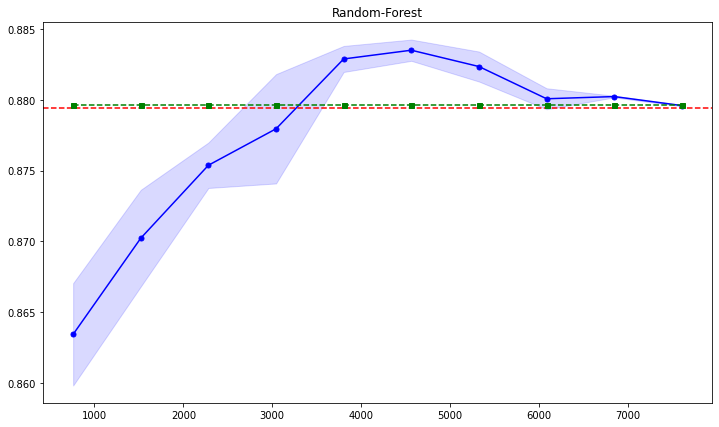

In [ ]:
# Evaluating the Random Forest
learn_curve_plot(name = 'Random-Forest', 
                 model = pipe_rf, 
                 xtrain = X_train, 
                 ytrain= y_train,
                ytest = y_val,
                xtest = X_val)

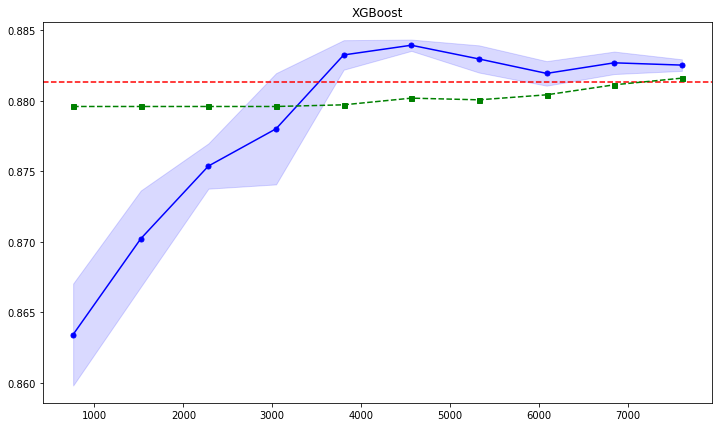

In [ ]:
# Evaluating the XGboost
learn_curve_plot(name = 'XGBoost', 
                 model = pipe_xgb, 
                 xtrain = X_train, 
                 ytrain= y_train,
                ytest = y_val,
                xtest = X_val)

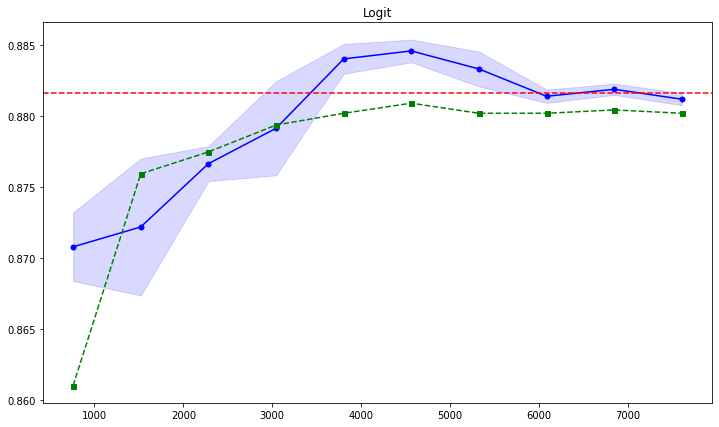

In [ ]:
# Evaluating the Logit
learn_curve_plot(name = 'Logit', 
                 model = pipe_logit, 
                 xtrain = X_train, 
                 ytrain= y_train,
                ytest = y_val,
                xtest = X_val)

We go for Logistics Regression Model, because it has low tendency of overfitting, this is proven in the learning curve.

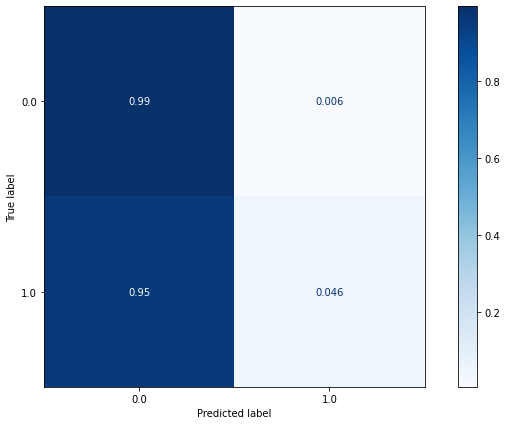

In [ ]:
plot_confusion_matrix(pipe_logit, X_val, y_val, normalize='true', cmap= 'Blues')

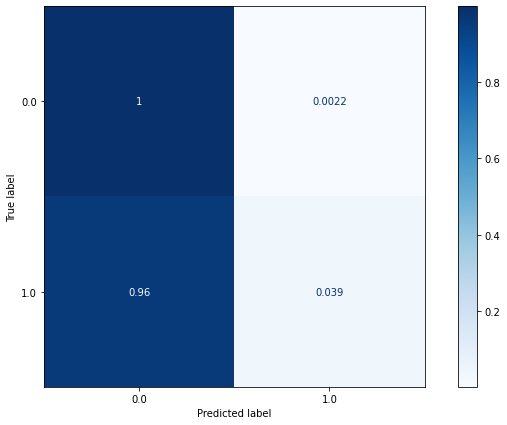

In [ ]:
plot_confusion_matrix(pipe_xgb, X_val, y_val, normalize='true', cmap= 'Blues')

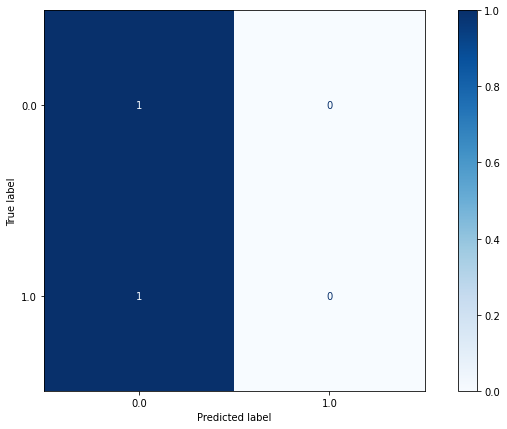

In [ ]:
plot_confusion_matrix(pipe_rf, X_val, y_val, normalize='true', cmap= 'Blues')

In [62]:
print('Initial train data: ', train.shape)
print('Train data after processing: ', traindf.shape)
print('---')
print('Initial test data: ', test.shape)
print('Test data after processing: ', testdf.shape)


Initial train data:  (12079, 14)
Train data after processing:  (12079, 20)
---
Initial test data:  (1202, 13)
Test data after processing:  (1202, 20)


In [ ]:
test_features =testdf.iloc[:, 1:]
pred = pipe_logit.predict(test_features )
sub_dict= {'ID': testdf['ID'], 'target': pred}
submission = pd.DataFrame(sub_dict).set_index('ID')
submission.to_csv('first_submission.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


# Undersampling and Over Sampling

In [68]:

# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

In [113]:
# Logit
c0 = RandomForestClassifier(n_estimators=100, class_weight='balanced')
c01 = DecisionTreeClassifier()
l1 = LogisticRegression(C = 0.01, max_iter=120000)

ov = RandomOverSampler()
ud = RandomUnderSampler()
logit2 = Pipeline([('t', transformer), 
                   ('under', ud), ('over', ov),
                   
                  ('feature select', SelectFromModel(l1)),
                   ('model', c0)])
logit2.fit(X_train,y_train)

logit2.predict(X_val)
y_lg2_prd= logit2.predict(X_val)
print('acc score -> '+str(logit2.score(X_val, y_val)))
print('f1-score -> '+str(f1_score(y_val, y_lg2_prd)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


acc score -> 0.6396247240618101
f1-score -> 0.3274974253347065


In [161]:
# XGBoost
# Initialize the XGBoost Claassifier
c0 = RandomForestClassifier(n_estimators=100, class_weight='balanced')
c01 = DecisionTreeClassifier()
l1 = LogisticRegression(C = 100, max_iter=120000, class_weight='balanced')

xgb0= XGBClassifier(silent=True,                     
                      scale_pos_weight=0.9,
                      learning_rate=0.001,  
                      colsample_bytree = 0.2,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      reg_alpha = 1,
                      max_depth=10, 
                      gamma=1)

ov = RandomOverSampler()
ud = RandomUnderSampler()
xgb2 = Pipeline([  ('t', transformer), 
                   ('over', ud), ('under', ud),('model selection', SelectFromModel(c0)),
                   ('model', xgb0)]);

xgb2.fit(X_train,y_train);

preds =xgb2.predict(X_val) 
y_xgb2_prd= preds
print('acc score -> '+str(xgb2.score(X_val, y_val)))
print('f1-score -> '+str(f1_score(y_val, y_xgb2_prd)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


acc score -> 0.6931567328918322
f1-score -> 0.35046728971962615


In [154]:
print(classification_report(y_val, y_xgb2_prd))

              precision    recall  f1-score   support

         0.0       0.94      0.70      0.81      3187
         1.0       0.24      0.70      0.36       437

    accuracy                           0.70      3624
   macro avg       0.59      0.70      0.58      3624
weighted avg       0.86      0.70      0.75      3624



# ROC plot

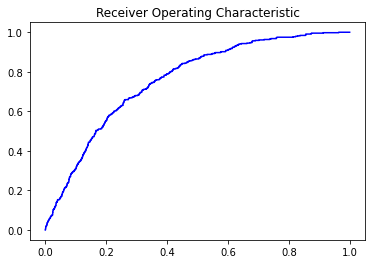

In [129]:
from sklearn.metrics import roc_curve, auc

xgb_probs =  xgb2.predict_proba(X_val)


preds = xgb_probs[:,1]
fpr, tpr, threshold = roc_curve(y_val, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

In [107]:
test_features =testdf.iloc[:, 1:]
pred = xgb2.predict(test_features )
sub_dict= {'ID': testdf['ID'], 'target': pred}
submission = pd.DataFrame(sub_dict).set_index('ID')
submission.to_csv('3nd_submission.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
